# Sales Forecast with Deep Learning (LSTM)

In [7]:
from google.colab import files
uploaded = files.upload()

Saving items.csv to items.csv


In [0]:
# import packages

import numpy as np 
import pandas as pd 

from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.metrics import mean_squared_error
from numpy import sqrt

from sklearn.preprocessing import StandardScaler,MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [29]:
train = pd.read_csv('sales_train_v2.csv')
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [31]:
train_clean = train.drop(labels = ['date', 'item_price'], axis = 1)

,date_block_num,shop_id,item_id,item_cnt_day
0,0,59,22154,1.0
1,0,25,2552,1.0
2,0,25,2552,-1.0
3,0,25,2554,1.0
4,0,25,2555,1.0


In [32]:
# change the item count per day to item count per month by using group
train_clean = train_clean.groupby(["item_id","shop_id","date_block_num"]).sum().reset_index()
train_clean = train_clean.rename(index=str, columns = {"item_cnt_day":"item_cnt_month"})
train_clean = train_clean[["item_id","shop_id","date_block_num","item_cnt_month"]]
train_clean.head()

,item_id,shop_id,date_block_num,item_cnt_month
0,0,54,20,1.0
1,1,55,15,2.0
2,1,55,18,1.0
3,1,55,19,1.0
4,1,55,20,1.0


To save time for forecasting, we select a shop_id and item_id to make prediction

In [107]:
# shop_id =2, item_id = 5037

sample = train_clean[["shop_id","item_id","date_block_num","item_cnt_month"]]
sample = sample.loc[sample['shop_id'] == 2]
sample = sample.loc[sample['item_id'] == 5037]
sample

,shop_id,item_id,date_block_num,item_cnt_month
400420,2,5037,21,1.0
400421,2,5037,23,4.0
400422,2,5037,24,2.0
400423,2,5037,25,1.0
400424,2,5037,26,1.0
400425,2,5037,30,2.0
400426,2,5037,31,1.0
400427,2,5037,32,1.0


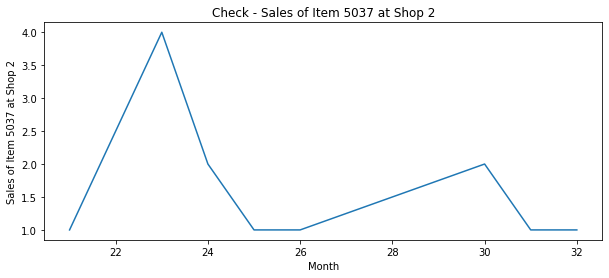

In [108]:
plt.figure(figsize=(10,4))
plt.title('Check - Sales of Item 5037 at Shop 2')
plt.xlabel('Month')
plt.ylabel('Sales of Item 5037 at Shop 2')
plt.plot(sample["date_block_num"],sample["item_cnt_month"]);


In [75]:
print( len(train_clean['shop_id'].unique()) )
print( len(train_clean['item_id'].unique()) )
print( len(train_clean['date_block_num'].unique()) )

60
21807
34


In [0]:
# make a df according to the pre-selected shop_id and item_id

month_list=[i for i in range(num_month+ 1)]
shop = []
for i in range(num_month+1):
    shop.append(2)
item = []
for i in range(num_month+1):
    item.append(5037)
months_full = pd.DataFrame({'shop_id':shop, 'item_id':item,'date_block_num':month_list})

In [0]:
# complete dataset for the selected dataset

num_month = train['date_block_num'].max()

sales_33month = pd.merge(sample, months_full, how='right', on=['shop_id','item_id','date_block_num'])
sales_33month = sales_33month.sort_values(by=['date_block_num'])
sales_33month.fillna(0.00,inplace=True)
sales_33month

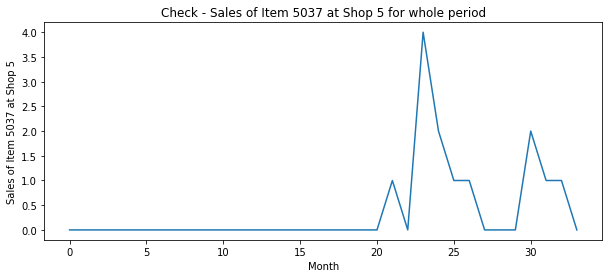

In [114]:
plt.figure(figsize=(10,4))
plt.title('Check - Sales of Item 5037 at Shop 2 for whole period')
plt.xlabel('Month')
plt.ylabel('Sales of Item 5037 at Shop 2')
plt.plot(sales_33month["date_block_num"],sales_33month["item_cnt_month"]);

In [115]:
for i in range(1,6):
    sales_33month["T_" + str(i)] = sales_33month.item_cnt_month.shift(i)
sales_33month.fillna(0.0, inplace=True)
sales_33month.head()

,shop_id,item_id,date_block_num,item_cnt_month,T_1,T_2,T_3,T_4,T_5
8,2,5037,0,0.0,0.0,0.0,0.0,0.0,0.0
9,2,5037,1,0.0,0.0,0.0,0.0,0.0,0.0
10,2,5037,2,0.0,0.0,0.0,0.0,0.0,0.0
11,2,5037,3,0.0,0.0,0.0,0.0,0.0,0.0
12,2,5037,4,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
df = sales_33month[['shop_id','item_id','date_block_num','T_1','T_2','T_3','T_4','T_5', 'item_cnt_month']].reset_index()
df = df.drop(labels = ['index'], axis = 1)

In [0]:
# train test split
train_df = df[:-3]
val_df = df[-3:]
x_train,y_train = train_df.drop(["item_cnt_month"],axis=1),train_df.item_cnt_month
x_val,y_val = val_df.drop(["item_cnt_month"],axis=1),val_df.item_cnt_month

LSTM Modeling

In [0]:
model_lstm = Sequential()
model_lstm.add(LSTM(15, input_shape=(1,8)))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [0]:
# Reshape the data between -1 and 1 and to 3D
scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(-1, 1))
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.fit_transform(x_val)

In [0]:
x_train_reshaped = x_train_scaled.reshape((x_train_scaled.shape[0], 1, x_train_scaled.shape[1]))
x_val_resaped = x_valid_scaled.reshape((x_valid_scaled.shape[0], 1, x_valid_scaled.shape[1]))

In [127]:
history = model_lstm.fit(x_train_reshaped, y_train, validation_data=(x_val_resaped, y_val),epochs=30, batch_size=12, verbose=2, shuffle=False)
y_pre = model_lstm.predict(x_val_resaped)

Train on 31 samples, validate on 3 samples
Epoch 1/30
 - 0s - loss: 0.4747 - acc: 0.7742 - val_loss: 0.5605 - val_acc: 0.3333
Epoch 2/30
 - 0s - loss: 0.4738 - acc: 0.7742 - val_loss: 0.5611 - val_acc: 0.3333
Epoch 3/30
 - 0s - loss: 0.4730 - acc: 0.7742 - val_loss: 0.5617 - val_acc: 0.3333
Epoch 4/30
 - 0s - loss: 0.4721 - acc: 0.8065 - val_loss: 0.5623 - val_acc: 0.3333
Epoch 5/30
 - 0s - loss: 0.4713 - acc: 0.8065 - val_loss: 0.5630 - val_acc: 0.3333
Epoch 6/30
 - 0s - loss: 0.4704 - acc: 0.8065 - val_loss: 0.5637 - val_acc: 0.3333
Epoch 7/30
 - 0s - loss: 0.4696 - acc: 0.8065 - val_loss: 0.5644 - val_acc: 0.3333
Epoch 8/30
 - 0s - loss: 0.4688 - acc: 0.8065 - val_loss: 0.5651 - val_acc: 0.3333
Epoch 9/30
 - 0s - loss: 0.4680 - acc: 0.8065 - val_loss: 0.5659 - val_acc: 0.3333
Epoch 10/30
 - 0s - loss: 0.4672 - acc: 0.8065 - val_loss: 0.5667 - val_acc: 0.3333
Epoch 11/30
 - 0s - loss: 0.4664 - acc: 0.8065 - val_loss: 0.5675 - val_acc: 0.3333
Epoch 12/30
 - 0s - loss: 0.4656 - acc: 0.

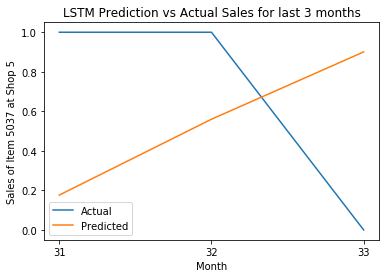

In [102]:
fig, ax = plt.subplots()
ax.plot(x_val['date_block_num'], y_val, label='Actual')
ax.plot(x_val['date_block_num'], y_pre, label='Predicted')
plt.title('LSTM Prediction vs Actual Sales for last 3 months')
plt.xlabel('Month')
plt.xticks(x_val['date_block_num'])
plt.ylabel('Sales of Item 5037 at Shop 5')
ax.legend()
plt.show()

In [125]:
rmse = sqrt(mean_squared_error(y_val,y_pre))
print('RMSE: ', rmse)

RMSE:  0.7061145372913963
